<a href="https://colab.research.google.com/github/geun-hyoung/python_object_detection_ocr/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
!pip install pytesseract
!pip install opencv-python
!pip install ultralytics
!pip install easyocr
!pip install paddlepaddle
!pip install paddleocr

In [2]:
import os
os.environ['TESSDATA_PREFIX'] = '/usr/share/tesseract-ocr/4.00/tessdata'

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Preprocessing

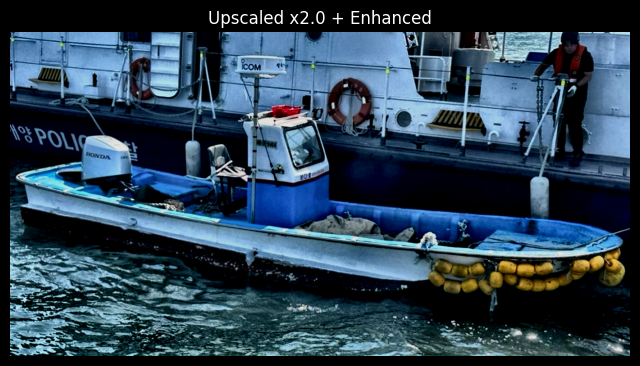

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ============== 설정 ==============
IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/7.jpg'  # 경로에 맞게 수정
MODEL_WEIGHTS = 'yolov8l-seg.pt'
UPSCALE_FACTOR = 2.0
# Enhancement tunables (조정해가며 테스트)
CLAHE_CLIP = 3.0           # CLAHE 강도 (1.0~3.0 권장)
CLAHE_TILE = (8,8)         # CLAHE 타일 크기
BILATERAL_D = 5            # bilateral 필터 직경 (작게 유지)
BILATERAL_SIGMA_COLOR = 10 # bilateral 색상 시그마 (작게: 획 보존)
BILATERAL_SIGMA_SPACE = 50 # bilateral 거리 시그마
SHARP_ALPHA = 0.3          # 언샤프 강도 (0 = 없음, 0.3~0.8 권장)
GAUSS_SIGMA = 1.0          # 언샤프용 가우시안 시그마
GAMMA = 1              # 감마 (>1 밝게, <1 어둡게)
BRIGHTNESS = -50         # 밝기 보정 (정수, 음수 가능)
CONTRAST_ALPHA = 1.1       # 전역 대비 스케일 (1.0 = 유지)
# ===================================

# 1) 이미지 로드
img_ori = cv2.imread(IMG_PATH)
if img_ori is None:
    raise FileNotFoundError(f"Image not found: {IMG_PATH}")

# 2) 업스케일 (해상도 증가) - 원본 유지 구조 그대로
if UPSCALE_FACTOR != 1.0:
    h, w = img_ori.shape[:2]
    new_w, new_h = int(w * UPSCALE_FACTOR), int(h * UPSCALE_FACTOR)
    img_ori = cv2.resize(img_ori, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

# 3) Enhancement pipeline (업스케일 직후 적용)
img_work = img_ori.copy()

# 3.1) CLAHE on L channel (로컬 대비 증폭 — 얇은 획 강조)
lab = cv2.cvtColor(img_work, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)
L_clahe = clahe.apply(L)
lab_clahe = cv2.merge((L_clahe, A, B))
img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# 3.2) 약한 에지 보존형 노이즈 제거 (bilateral) — 너무 강하면 획이 날아감
img_denoised = cv2.bilateralFilter(img_clahe, d=BILATERAL_D,
                                   sigmaColor=BILATERAL_SIGMA_COLOR,
                                   sigmaSpace=BILATERAL_SIGMA_SPACE)

# 3.3) 전역 대비·밝기 조정 (간단 선형 변환 + 감마)
# contrast/brightness: new = img * alpha + beta
img_cv = img_denoised.astype(np.float32)
img_cv = img_cv * CONTRAST_ALPHA + BRIGHTNESS
# gamma correction
if GAMMA != 1.0:
    inv_gamma = 1.0 / GAMMA
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    img_cv = cv2.LUT(np.clip(img_cv,0,255).astype('uint8'), table)
else:
    img_cv = np.clip(img_cv,0,255).astype('uint8')

# 3.4) Unsharp mask (언샤프) — 가장자리 강화
blur = cv2.GaussianBlur(img_cv, (0,0), GAUSS_SIGMA)
img_sharp = cv2.addWeighted(img_cv, 1.0 + SHARP_ALPHA, blur, -SHARP_ALPHA, 0)
img_sharp = np.clip(img_sharp, 0, 255).astype('uint8')

# 3.5) 선택적 경계 정리 (라이트 노이즈 제거) - 아주 약하게만
# img_sharp = cv2.medianBlur(img_sharp, 3)

# 4) 결과 대체(이후 파이프라인은 img_ori 대신 img_for_processing 사용)
img_ori = img_sharp.copy()

height, width, channel = img_ori.shape

# show upscaled + enhanced image
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Upscaled x{UPSCALE_FACTOR} + Enhanced')
plt.show()


0: 352x640 1 person, 2 boats, 1 chair, 67.1ms
Speed: 4.3ms preprocess, 67.1ms inference, 138.4ms postprocess per image at shape (1, 3, 352, 640)


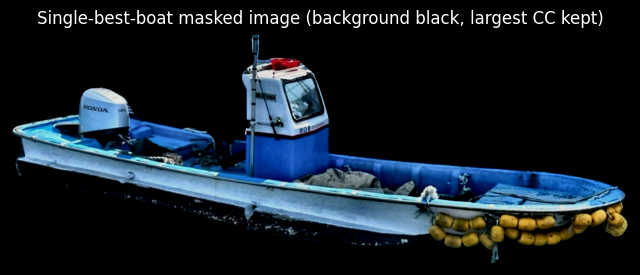

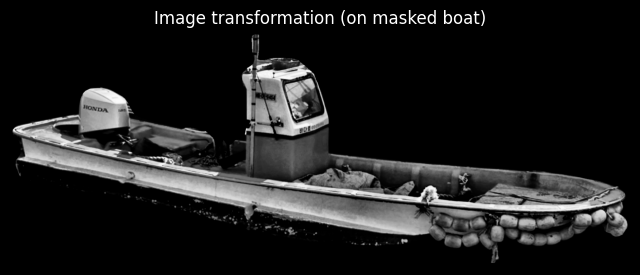

In [6]:
# 2) YOLOv8-seg 로드 및 인퍼런스
try:
    from ultralytics import YOLO
except Exception as e:
    raise ImportError("ultralytics가 설치되어 있지 않습니다. 'pip install ultralytics' 수행 후 다시 실행하세요.") from e

model = YOLO(MODEL_WEIGHTS)
results = model(img_ori, imgsz=640, retina_masks=True)  # retina_masks -> mask at image scale when possible

# 기본: 전체 이미지 사용 (fallback)
img_for_processing = img_ori.copy()
boat_mask_combined = np.zeros((height, width), dtype=np.uint8)
found_boat = False

# 3) 결과에서 boat 클래스 중 confidence 최고 하나 선택
if len(results) > 0:
    r = results[0]
    masks_obj = getattr(r, 'masks', None)
    boxes_obj = getattr(r, 'boxes', None)
    names = getattr(model, 'names', None)

    # try reading mask tensor and boxes info robustly
    mask_data = None
    try:
        if masks_obj is not None:
            mask_data = masks_obj.data.cpu().numpy()  # (N, H, W)
    except Exception:
        try:
            if masks_obj is not None:
                mask_data = np.asarray(masks_obj.data)
        except Exception:
            mask_data = None

    confs = None
    cls_idxs = None
    try:
        if boxes_obj is not None:
            confs = boxes_obj.conf.cpu().numpy()
            cls_idxs = boxes_obj.cls.cpu().numpy().astype(int)
    except Exception:
        try:
            if boxes_obj is not None:
                confs = np.array([float(x) for x in boxes_obj.conf])
                cls_idxs = np.array([int(x) for x in boxes_obj.cls])
        except Exception:
            confs, cls_idxs = None, None

    # collect indices of detections where class == 'boat'
    candidate_indices = []
    if cls_idxs is not None and names is not None:
        for idx, cls_id in enumerate(cls_idxs):
            class_name = names[int(cls_id)] if int(cls_id) in names else str(int(cls_id))
            if class_name.lower() == 'boat':
                candidate_indices.append(idx)

    # choose index with highest confidence among candidates
    chosen_idx = None
    if candidate_indices:
        if confs is not None:
            # choose candidate index with max conf
            best = max(candidate_indices, key=lambda i: confs[i])
            chosen_idx = int(best)
        else:
            chosen_idx = int(candidate_indices[0])

    # build mask from mask_data if available
    if chosen_idx is not None and mask_data is not None:
        try:
            m = mask_data[chosen_idx]  # soft mask in [0,1]
            m_bin = (m > 0.5).astype(np.uint8)
            # resize if needed
            if m_bin.shape[0] != height or m_bin.shape[1] != width:
                m_bin = cv2.resize(m_bin, (width, height), interpolation=cv2.INTER_NEAREST)
                m_bin = (m_bin > 0).astype(np.uint8)
            boat_mask_combined = m_bin
            found_boat = True
        except Exception:
            found_boat = False

    # fallback: if mask_data missing, attempt polygons (masks.xy)
    if not found_boat and masks_obj is not None:
        try:
            polys = masks_obj.xy  # list of polygons per detection (or list of lists)
            if polys is not None and cls_idxs is not None:
                # pick candidate polygons
                candidate_polys = []
                for idx, poly in enumerate(polys):
                    class_name = names[int(cls_idxs[idx])] if names is not None and int(cls_idxs[idx]) in names else ''
                    if class_name.lower() == 'boat':
                        candidate_polys.append((idx, poly))
                if candidate_polys:
                    if confs is not None:
                        best = max(candidate_polys, key=lambda t: confs[t[0]])
                        chosen_poly = best[1]
                    else:
                        chosen_poly = candidate_polys[0][1]
                    # rasterize polygon(s) (poly may be list of rings)
                    mask_tmp = np.zeros((height, width), dtype=np.uint8)
                    if isinstance(chosen_poly, (list, tuple)) and len(chosen_poly) and isinstance(chosen_poly[0], (list, tuple, np.ndarray)):
                        # multiple rings/polys
                        for ring in chosen_poly:
                            pts = np.array([ring], dtype=np.int32)
                            cv2.fillPoly(mask_tmp, pts, 1)
                    else:
                        pts = np.array([chosen_poly], dtype=np.int32)
                        cv2.fillPoly(mask_tmp, pts, 1)
                    boat_mask_combined = mask_tmp
                    found_boat = True
        except Exception:
            pass

# 4) 최종: 선택된 마스크가 있으면 -> largest connected component만 살리고 배경 블랙
if not found_boat:
    print("YOLOv8에서 'boat'를 검출하지 못했거나 마스크가 없음. 전체 이미지 사용 (마스킹 안함).")
    img_for_processing = img_ori.copy()
else:
    # ensure binary 0/1
    final_soft = (boat_mask_combined > 0).astype(np.uint8)

    # connected components: keep the largest (ignore background label 0)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_soft, connectivity=8)
    if num_labels <= 1:
        final_mask = final_soft.copy()
    else:
        # areas for labels 1..N-1
        areas = stats[1:, cv2.CC_STAT_AREA]
        max_idx_rel = int(np.argmax(areas))
        max_label = max_idx_rel + 1
        final_mask = (labels == max_label).astype(np.uint8)

        # optional cleanup: closing to fill small holes
        k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, k_close, iterations=1)
        # after closing, ensure again largest CC
        num_labels2, labels2, stats2, _ = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
        if num_labels2 > 1:
            areas2 = stats2[1:, cv2.CC_STAT_AREA]
            max_idx2 = int(np.argmax(areas2))
            max_label2 = max_idx2 + 1
            final_mask = (labels2 == max_label2).astype(np.uint8)

    # create 0/255 uint8 mask
    boat_mask_uint8 = (final_mask * 255).astype(np.uint8)

    # apply mask: background -> black
    img_for_processing = img_ori.copy()
    inv_mask = (boat_mask_uint8 == 0)
    img_for_processing[inv_mask] = (0,0,0)

    # crop to mask bbox (optional, reduces processing area)
    ys, xs = np.where(boat_mask_uint8 > 0)
    if len(xs) > 0 and len(ys) > 0:
        x1, x2 = int(xs.min()), int(xs.max())
        y1, y2 = int(ys.min()), int(ys.max())
        pad = 8
        x1 = max(0, x1-pad); y1 = max(0, y1-pad)
        x2 = min(width, x2+pad); y2 = min(height, y2+pad)
        img_for_processing = img_for_processing[y1:y2, x1:x2]
    else:
        img_for_processing = img_ori.copy()

# show masked image used for further processing
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2RGB))
plt.title('Single-best-boat masked image (background black, largest CC kept)')
plt.axis('off')
plt.show()

gray = cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2GRAY)

# 4) 결과 보여주기 (처리본 한 장씩)
plt.figure(figsize=(8,8))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Image transformation (on masked boat)')
plt.show()


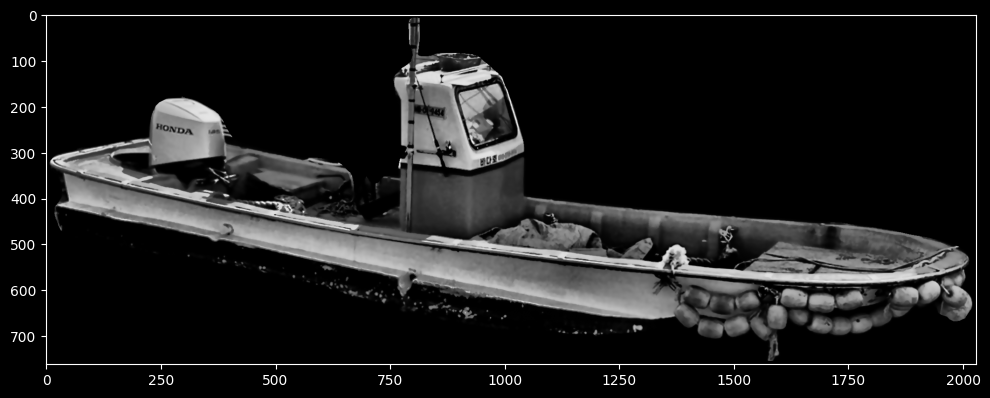

In [7]:
gray_clahe=gray

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray_clahe, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray_clahe, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray_clahe, imgTopHat)
gray_clahe = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

img_blurred = cv2.bilateralFilter(gray_clahe, d=9, sigmaColor=15, sigmaSpace=85)
gray_clahe = img_blurred

plt.figure(figsize=(12, 10))
plt.imshow(gray_clahe, cmap='gray')

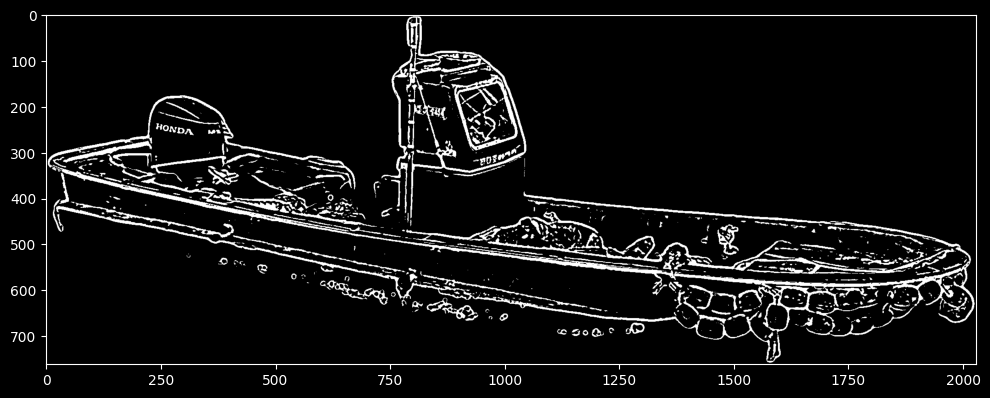

In [8]:
img_thresh = cv2.adaptiveThreshold(
    gray_clahe,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

# Find Contours

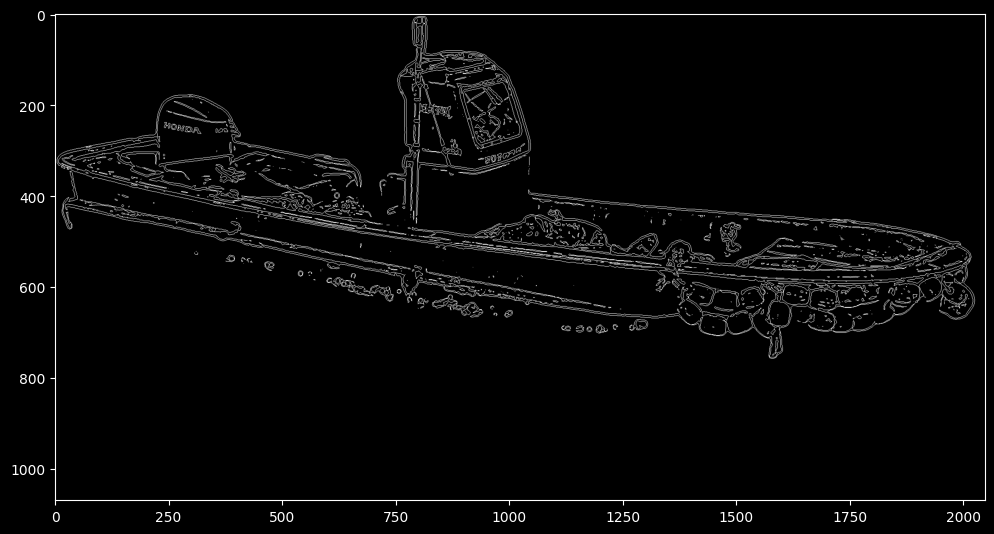

In [9]:
contours,_  = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# Prepare Data

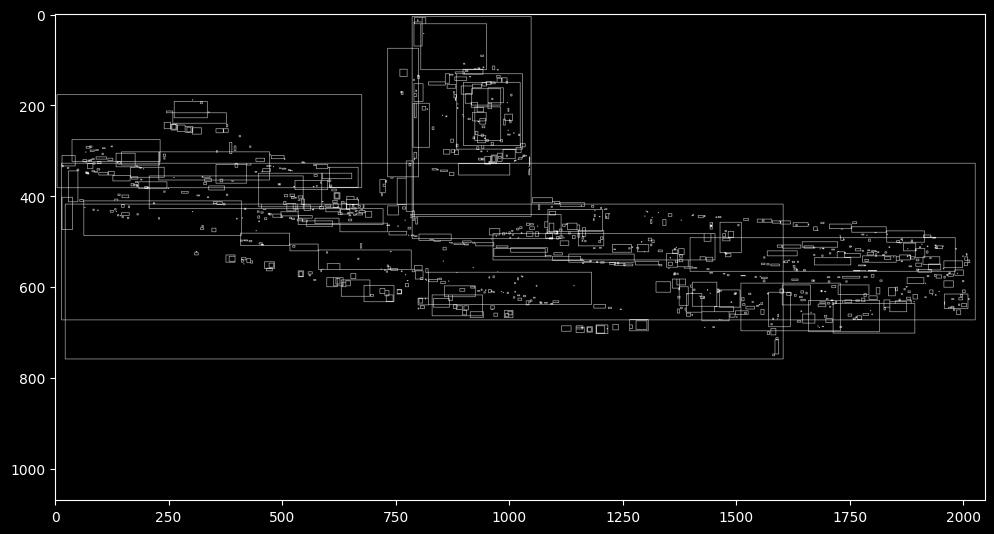

In [10]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=1)

    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Char Size

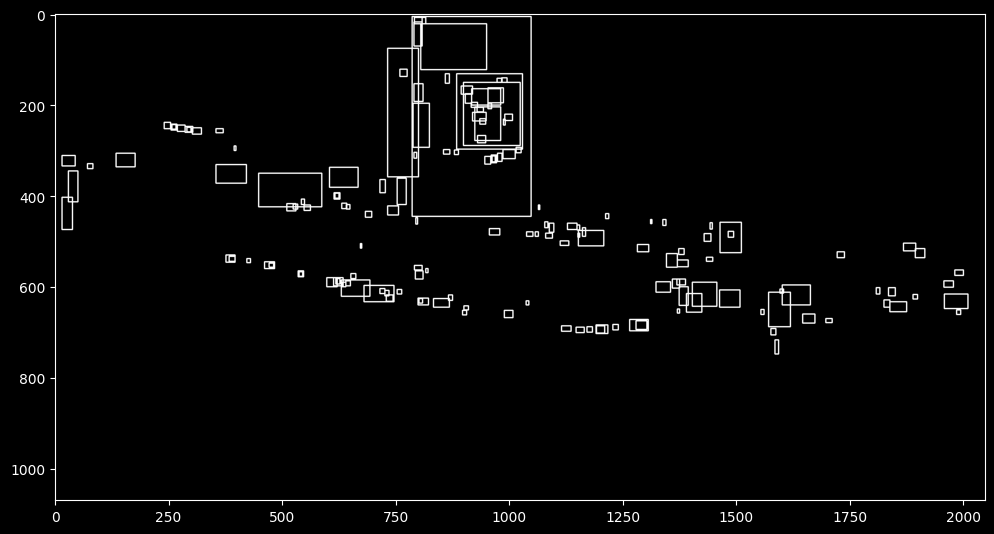

In [11]:
# --- 자동 상대값 설정 (이미지 크기 기반) ---
img_area = height * width
MIN_AREA = max(8, int(img_area * 0.000005))   # 매우 작게 허용 (예: 8 픽셀 이상)
MIN_WIDTH = 1                                  # 최소 너비 1픽셀 허용
MIN_HEIGHT = max(8, int(height * 0.004))       # 최소 높이 작게 허용 (예: 4픽셀)
MIN_RATIO, MAX_RATIO = 0.2, 2.0               # 매우 얇거나 넓은 것도 허용 (후에 병합으로 정리)

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Arrangement of Contours

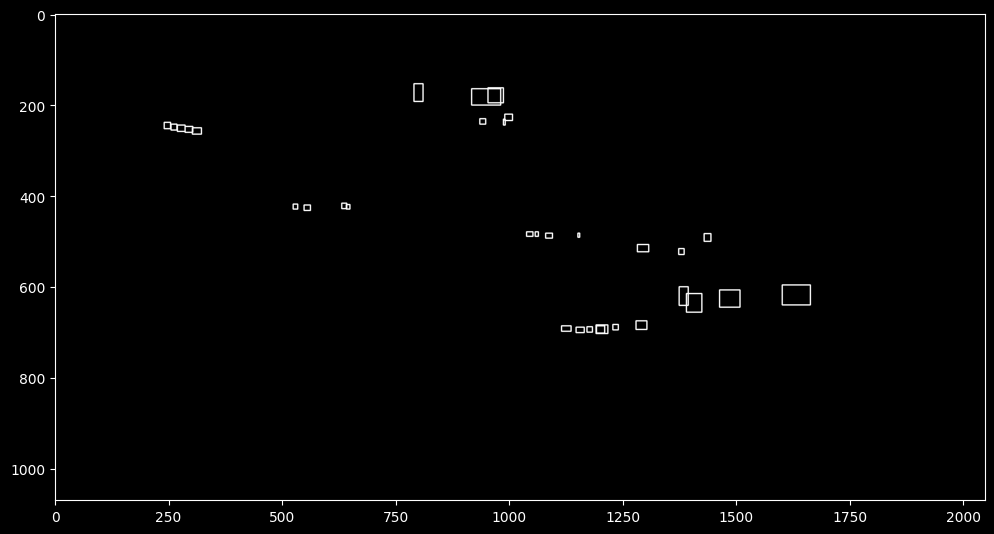

In [12]:
# 관대(유하게) 설정 (원래값보다 느슨하게)
MAX_DIAG_MULTIPLYER = 5   # 원래 5 -> 더 멀리 있는 문자까지 허용
MAX_ANGLE_DIFF = 12       # 원래 12 -> 더 기울어진 라인 허용
MAX_AREA_DIFF = 0.8         # 원래 0.5 -> 면적 차 80%까지 허용
MAX_WIDTH_DIFF =  0.8        # 원래 0.8 -> 너비 차 더 관대하게
MAX_HEIGHT_DIFF = 0.2       # 원래 0.2 -> 높이 차 더 관대하게
MIN_N_MATCHED = 3           # 원래 3 -> 2개만 있어도 그룹 인정 (짧은 시퀀스 허용)


def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

        # recursive
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Rotate Plate Images

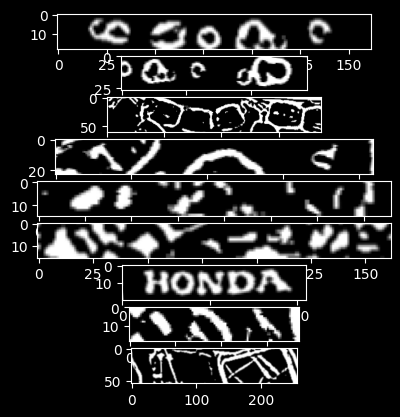

In [13]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# Another Thresholding to Find Chars

/tmp/ipython-input-2294181140.py:28: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  paddle_ocr = PaddleOCR(use_angle_cls=False, lang='en')
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/UVDoc`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_mode

PaddleOCR initialized.
EasyOCR initialized.

--- Plate 0 ---
  Plate 0 | pytesseract | --psm 7 | orig --> 'UY\n\x0c'
  Plate 0 | pytesseract | --psm 7 | inv --> '19Y\n\x0c'
  Plate 0 | pytesseract | --psm 6 | orig --> 'UY\n\x0c'
  Plate 0 | pytesseract | --psm 6 | inv --> '19Y\n\x0c'
  Plate 0 | pytesseract | --psm 8 | orig --> 'UY\n\x0c'
  Plate 0 | pytesseract | --psm 8 | inv --> '19Y\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['9 =']
  >> 선택된 후보: 9 -> normalized: 9-9-9 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


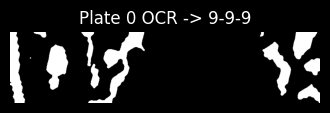


--- Plate 1 ---
  Plate 1 | pytesseract | --psm 7 | orig --> '\x0c'
  Plate 1 | pytesseract | --psm 7 | inv --> 'RSS\n\x0c'
  Plate 1 | pytesseract | --psm 6 | orig --> 'QBROS\nWTO E\nNS\n\x0c'
  Plate 1 | pytesseract | --psm 6 | inv --> 'AROS\nNR 2\nTS NS\nN\n\x0c'
  Plate 1 | pytesseract | --psm 8 | orig --> '\x0c'
  Plate 1 | pytesseract | --psm 8 | inv --> 'NS\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  >> 선택된 후보: AROSNR2TSNSN -> normalized: AR-2-2 (total_score=9)
     detail: base=17, pattern=-8, src=--psm 6/inv


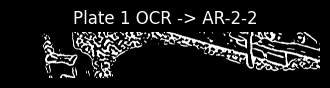


--- Plate 2 ---
  Plate 2 | pytesseract | --psm 7 | orig --> 'ANS\n\x0c'
  Plate 2 | pytesseract | --psm 7 | inv --> 'ASL\n\x0c'
  Plate 2 | pytesseract | --psm 6 | orig --> 'ANS\n\x0c'
  Plate 2 | pytesseract | --psm 6 | inv --> 'ASL\n\x0c'
  Plate 2 | pytesseract | --psm 8 | orig --> 'DSO\n\x0c'
  Plate 2 | pytesseract | --psm 8 | inv --> 'BSS\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  >> 선택된 후보: ANS -> normalized: AN-- (total_score=-17)
     detail: base=3, pattern=-20, src=--psm 7/orig


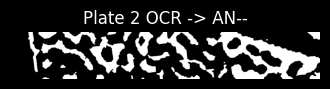


--- Plate 3 ---
  Plate 3 | pytesseract | --psm 7 | orig --> 'SWARYONOR\n\x0c'
  Plate 3 | pytesseract | --psm 7 | inv --> 'SARBYONYOR\n\x0c'
  Plate 3 | pytesseract | --psm 6 | orig --> 'SWARYONOR\n\x0c'
  Plate 3 | pytesseract | --psm 6 | inv --> 'SARBYONYOR\n\x0c'
  Plate 3 | pytesseract | --psm 8 | orig --> 'SRR\n\x0c'
  Plate 3 | pytesseract | --psm 8 | inv --> 'SRR\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['K', '3']
  >> 선택된 후보: 3 -> normalized: 3-3-3 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


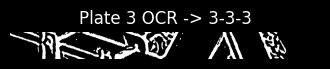


--- Plate 4 ---
  Plate 4 | pytesseract | --psm 7 | orig --> 'USCS\n\x0c'
  Plate 4 | pytesseract | --psm 7 | inv --> 'TPSCNEG\n\x0c'
  Plate 4 | pytesseract | --psm 6 | orig --> 'USCS\n\x0c'
  Plate 4 | pytesseract | --psm 6 | inv --> 'TPSCNEG\n\x0c'
  Plate 4 | pytesseract | --psm 8 | orig --> 'TSS\n\x0c'
  Plate 4 | pytesseract | --psm 8 | inv --> 'USSG\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  >> 선택된 후보: TPSCNEG -> normalized: TP-- (total_score=-10)
     detail: base=7, pattern=-17, src=--psm 7/inv


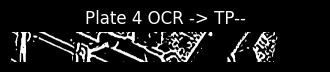


--- Plate 5 ---
  Plate 5 | pytesseract | --psm 7 | orig --> 'SRY\n\x0c'
  Plate 5 | pytesseract | --psm 7 | inv --> 'SREY\n\x0c'
  Plate 5 | pytesseract | --psm 6 | orig --> 'SRY\n\x0c'
  Plate 5 | pytesseract | --psm 6 | inv --> 'SREY\n\x0c'
  Plate 5 | pytesseract | --psm 8 | orig --> 'SRY\n\x0c'
  Plate 5 | pytesseract | --psm 8 | inv --> 'SREY\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['7,', '', 'Y', 'ak', 'R']
  >> 선택된 후보: 7 -> normalized: 7-7-7 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


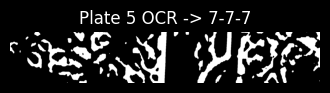


--- Plate 6 ---
  Plate 6 | pytesseract | --psm 7 | orig --> '-CURIL\n\x0c'
  Plate 6 | pytesseract | --psm 7 | inv --> 'GCURIL\n\x0c'
  Plate 6 | pytesseract | --psm 6 | orig --> '-CURIL\n\x0c'
  Plate 6 | pytesseract | --psm 6 | inv --> 'GCURIL\n\x0c'
  Plate 6 | pytesseract | --psm 8 | orig --> '-CURIL\n\x0c'
  Plate 6 | pytesseract | --psm 8 | inv --> 'GCURIL\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['Xc', 'Vk}']
  >> 선택된 후보: -CURIL -> normalized: CU-- (total_score=-11)
     detail: base=6, pattern=-17, src=--psm 7/orig


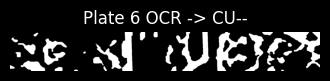


--- Plate 7 ---
  Plate 7 | pytesseract | --psm 7 | orig --> 'SESS\n\x0c'
  Plate 7 | pytesseract | --psm 7 | inv --> 'SESS\n\x0c'
  Plate 7 | pytesseract | --psm 6 | orig --> 'ATO PB 2 5\n\x0c'
  Plate 7 | pytesseract | --psm 6 | inv --> 'V1608 FANS 4\n\x0c'
  Plate 7 | pytesseract | --psm 8 | orig --> 'SESS\n\x0c'
  Plate 7 | pytesseract | --psm 8 | inv --> 'SESS\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['Ln', "'pa", '~1l', 'R2']
  >> 선택된 후보: V1608FANS4 -> normalized: VF-16-084 (total_score=180)
     detail: base=35, pattern=145, src=--psm 6/inv


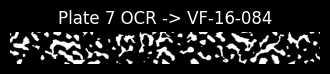


--- Plate 8 ---
  Plate 8 | pytesseract | --psm 7 | orig --> 'AX\n\x0c'
  Plate 8 | pytesseract | --psm 7 | inv --> 'AX\n\x0c'
  Plate 8 | pytesseract | --psm 6 | orig --> 'AX\n\x0c'
  Plate 8 | pytesseract | --psm 6 | inv --> 'AX\n\x0c'
  Plate 8 | pytesseract | --psm 8 | orig --> 'AX\n\x0c'
  Plate 8 | pytesseract | --psm 8 | inv --> 'AX\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['1']
  >> 선택된 후보: 1 -> normalized: 1-1-1 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


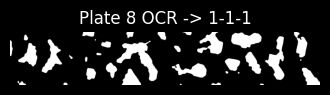


--- Plate 9 ---
  Plate 9 | pytesseract | --psm 7 | orig --> '2\n\x0c'
  Plate 9 | pytesseract | --psm 7 | inv --> 'NSN\n\x0c'
  Plate 9 | pytesseract | --psm 6 | orig --> '2\n\x0c'
  Plate 9 | pytesseract | --psm 6 | inv --> 'NSN\n\x0c'
  Plate 9 | pytesseract | --psm 8 | orig --> '2\n\x0c'
  Plate 9 | pytesseract | --psm 8 | inv --> 'NSN\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['DARG~', '1']
  >> 선택된 후보: 2 -> normalized: 2-2-2 (total_score=11)
     detail: base=6, pattern=5, src=--psm 7/orig


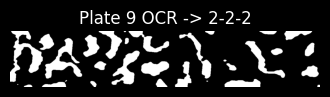


--- Plate 10 ---
  Plate 10 | pytesseract | --psm 7 | orig --> 'YONASEP\n\x0c'
  Plate 10 | pytesseract | --psm 7 | inv --> 'YOXNSEP\n\x0c'
  Plate 10 | pytesseract | --psm 6 | orig --> 'SOOTAM\nSP RS\n\x0c'
  Plate 10 | pytesseract | --psm 6 | inv --> '-G7FNNANTE\nQO S RNSI\n\x0c'
  Plate 10 | pytesseract | --psm 8 | orig --> 'YONASEP\n\x0c'
  Plate 10 | pytesseract | --psm 8 | inv --> 'YOXNSEP\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['{92 2', 'QQ', '2a']
  >> 선택된 후보: -G7FNNANTEQOSRNSI -> normalized: GF-7-7 (total_score=26)
     detail: base=22, pattern=4, src=--psm 6/inv


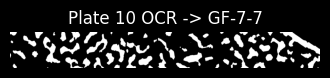


--- Plate 11 ---
  Plate 11 | pytesseract | --psm 7 | orig --> 'VV\n\x0c'
  Plate 11 | pytesseract | --psm 7 | inv --> 'VV\n\x0c'
  Plate 11 | pytesseract | --psm 6 | orig --> '-\nY - 4\n\x0c'
  Plate 11 | pytesseract | --psm 6 | inv --> '4\nX\n\x0c'
  Plate 11 | pytesseract | --psm 8 | orig --> 'AWNA\n\x0c'
  Plate 11 | pytesseract | --psm 8 | inv --> 'VAWOV\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['3i', '5c']
  >> 선택된 후보: -Y-4 -> normalized: Y-4-4 (total_score=36)
     detail: base=9, pattern=27, src=--psm 6/orig


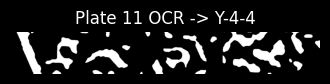


--- Plate 12 ---
  Plate 12 | pytesseract | --psm 7 | orig --> 'ISLNRDC\n\x0c'
  Plate 12 | pytesseract | --psm 7 | inv --> 'LTCN08\n\x0c'
  Plate 12 | pytesseract | --psm 6 | orig --> 'S\nISENEDC\n\x0c'
  Plate 12 | pytesseract | --psm 6 | inv --> 'HOLL\nLTEAEN04T\n\x0c'
  Plate 12 | pytesseract | --psm 8 | orig --> 'ISLNRDC\n\x0c'
  Plate 12 | pytesseract | --psm 8 | inv --> 'LTCN08\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['X~']
  >> 선택된 후보: LTCN08 -> normalized: LT-08-08 (total_score=75)
     detail: base=16, pattern=59, src=--psm 7/inv


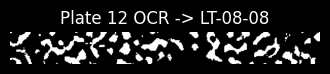


--- Plate 13 ---
  Plate 13 | pytesseract | --psm 7 | orig --> 'CAAESOIE\n\x0c'
  Plate 13 | pytesseract | --psm 7 | inv --> 'NR6SD-\n\x0c'
  Plate 13 | pytesseract | --psm 6 | orig --> 'V8N\nVTA ATP\n\x0c'
  Plate 13 | pytesseract | --psm 6 | inv --> 'VN\n2AA E8S-\n\x0c'
  Plate 13 | pytesseract | --psm 8 | orig --> 'CAAESOIE\n\x0c'
  Plate 13 | pytesseract | --psm 8 | inv --> 'NR6SD-\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['Ii7', '6', '5']
  >> 선택된 후보: VN2AAE8S- -> normalized: VN-28-28 (total_score=48)
     detail: base=19, pattern=29, src=--psm 6/inv


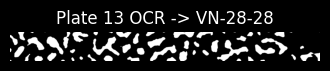


--- Plate 14 ---
  Plate 14 | pytesseract | --psm 7 | orig --> 'TCGKPSF\n\x0c'
  Plate 14 | pytesseract | --psm 7 | inv --> 'SEMUSUDIV81\n\x0c'
  Plate 14 | pytesseract | --psm 6 | orig --> 'TCGKPSF\n\x0c'
  Plate 14 | pytesseract | --psm 6 | inv --> 'SEMUSUDIV81\n\x0c'
  Plate 14 | pytesseract | --psm 8 | orig --> 'TCGKPSF\n\x0c'
  Plate 14 | pytesseract | --psm 8 | inv --> 'SEMUSUDIV81\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['1cS', '3', '7']
  >> 선택된 후보: SEMUSUDIV81 -> normalized: SE-81-81 (total_score=25)
     detail: base=21, pattern=4, src=--psm 7/inv


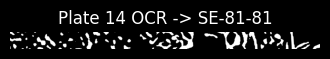


--- Plate 15 ---
  Plate 15 | pytesseract | --psm 7 | orig --> 'A\n\x0c'
  Plate 15 | pytesseract | --psm 7 | inv --> 'SINTER\n\x0c'
  Plate 15 | pytesseract | --psm 6 | orig --> 'S NM\n7 F\nA A S A 7S G-\n\x0c'
  Plate 15 | pytesseract | --psm 6 | inv --> 'VF Y S\n7 P 6\nA S - -\n\x0c'
  Plate 15 | pytesseract | --psm 8 | orig --> 'A\n\x0c'
  Plate 15 | pytesseract | --psm 8 | inv --> 'SINTER\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['"e']
  >> 선택된 후보: VFYS7P6AS- -> normalized: VF-76-76 (total_score=48)
     detail: base=20, pattern=28, src=--psm 6/inv


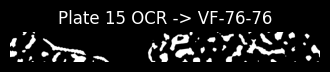


--- Plate 16 ---
  Plate 16 | pytesseract | --psm 7 | orig --> 'TK55TANG\n\x0c'
  Plate 16 | pytesseract | --psm 7 | inv --> 'TELS\n\x0c'
  Plate 16 | pytesseract | --psm 6 | orig --> 'TK55TANG\n\x0c'
  Plate 16 | pytesseract | --psm 6 | inv --> 'TELS\n\x0c'
  Plate 16 | pytesseract | --psm 8 | orig --> 'TK7CAN6\n\x0c'
  Plate 16 | pytesseract | --psm 8 | inv --> 'TTSG\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['5r2', '3']
  >> 선택된 후보: TK55TANG -> normalized: TK-55-55 (total_score=91)
     detail: base=18, pattern=73, src=--psm 7/orig


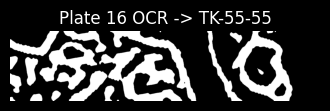


--- Plate 17 ---
  Plate 17 | pytesseract | --psm 7 | orig --> 'BRNCU\n\x0c'
  Plate 17 | pytesseract | --psm 7 | inv --> 'GEPESRSAGS\n\x0c'
  Plate 17 | pytesseract | --psm 6 | orig --> 'BRCARNCANNCEOO\nNSU R A A W A P S\n\x0c'
  Plate 17 | pytesseract | --psm 6 | inv --> 'GEASREREALGS\nNU - CP NS -\n\x0c'
  Plate 17 | pytesseract | --psm 8 | orig --> 'BRNCU\n\x0c'
  Plate 17 | pytesseract | --psm 8 | inv --> 'GEPESRSAGS\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['6']
  >> 선택된 후보: 6 -> normalized: 6-6-6 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


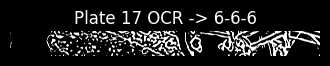


--- Plate 18 ---
  Plate 18 | pytesseract | --psm 7 | orig --> 'V4\n\x0c'
  Plate 18 | pytesseract | --psm 7 | inv --> 'GAA\n\x0c'
  Plate 18 | pytesseract | --psm 6 | orig --> 'PZ\nW\nA\n\x0c'
  Plate 18 | pytesseract | --psm 6 | inv --> 'V\nA\nA\n\x0c'
  Plate 18 | pytesseract | --psm 8 | orig --> 'V4\n\x0c'
  Plate 18 | pytesseract | --psm 8 | inv --> 'GAA\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['U', '4', '6i']
  >> 선택된 후보: 4 -> normalized: 4-4-4 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


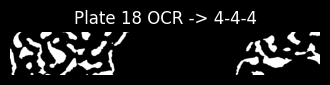


--- Plate 19 ---
  Plate 19 | pytesseract | --psm 7 | orig --> '9D\n\x0c'
  Plate 19 | pytesseract | --psm 7 | inv --> 'O-LUZN\n\x0c'
  Plate 19 | pytesseract | --psm 6 | orig --> '9D\n\x0c'
  Plate 19 | pytesseract | --psm 6 | inv --> 'O-LUZN\n\x0c'
  Plate 19 | pytesseract | --psm 8 | orig --> 'O-LUN\n\x0c'
  Plate 19 | pytesseract | --psm 8 | inv --> 'O7LUN\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['0']
  >> 선택된 후보: 0 -> normalized: 0-0-0 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


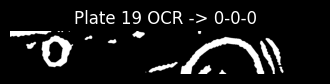


--- Plate 20 ---
  Plate 20 | pytesseract | --psm 7 | orig --> 'W2TPN\n\x0c'
  Plate 20 | pytesseract | --psm 7 | inv --> 'WTPV\n\x0c'
  Plate 20 | pytesseract | --psm 6 | orig --> 'W2TPN\n\x0c'
  Plate 20 | pytesseract | --psm 6 | inv --> 'WTPV\n\x0c'
  Plate 20 | pytesseract | --psm 8 | orig --> 'N2G0\n\x0c'
  Plate 20 | pytesseract | --psm 8 | inv --> 'VWTGSE\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['U', 'W']
  >> 선택된 후보: N2G0 -> normalized: NG-20-20 (total_score=26)
     detail: base=14, pattern=12, src=--psm 8/orig


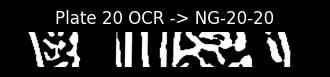


--- Plate 21 ---
  Plate 21 | pytesseract | --psm 7 | orig --> 'A SD\n\x0c'
  Plate 21 | pytesseract | --psm 7 | inv --> 'IST SD\n\x0c'
  Plate 21 | pytesseract | --psm 6 | orig --> 'A\nSD\n\x0c'
  Plate 21 | pytesseract | --psm 6 | inv --> 'IST\nSD\n\x0c'
  Plate 21 | pytesseract | --psm 8 | orig --> 'W4Y\n\x0c'
  Plate 21 | pytesseract | --psm 8 | inv --> 'WZ\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['33A', '6']
  >> 선택된 후보: 6 -> normalized: 6-6-6 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


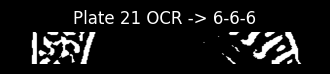


--- Plate 22 ---
  Plate 22 | pytesseract | --psm 7 | orig --> 'YO-O\n\x0c'
  Plate 22 | pytesseract | --psm 7 | inv --> 'YO-O\n\x0c'
  Plate 22 | pytesseract | --psm 6 | orig --> 'YO-O\n\x0c'
  Plate 22 | pytesseract | --psm 6 | inv --> 'YO-O\n\x0c'
  Plate 22 | pytesseract | --psm 8 | orig --> 'YO-O\n\x0c'
  Plate 22 | pytesseract | --psm 8 | inv --> 'YO-O\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['0', "'8 -"]
  >> 선택된 후보: 8- -> normalized: 8-8-8 (total_score=12)
     detail: base=7, pattern=5, src=easyocr/ext


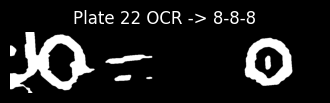


--- Plate 23 ---
  Plate 23 | pytesseract | --psm 7 | orig --> 'S\n\x0c'
  Plate 23 | pytesseract | --psm 7 | inv --> 'W\n\x0c'
  Plate 23 | pytesseract | --psm 6 | orig --> 'S\n\x0c'
  Plate 23 | pytesseract | --psm 6 | inv --> 'W\n\x0c'
  Plate 23 | pytesseract | --psm 8 | orig --> 'V\n\x0c'
  Plate 23 | pytesseract | --psm 8 | inv --> 'V\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['(0']
  >> 선택된 후보: 0 -> normalized: 0-0-0 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


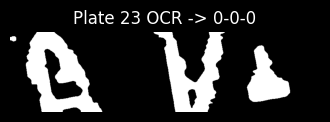


--- Plate 24 ---
  Plate 24 | pytesseract | --psm 7 | orig --> 'IN\n\x0c'
  Plate 24 | pytesseract | --psm 7 | inv --> 'WSS\n\x0c'
  Plate 24 | pytesseract | --psm 6 | orig --> 'IN\nYN O F\n\x0c'
  Plate 24 | pytesseract | --psm 6 | inv --> 'WSS\nWRCS O I - F\n\x0c'
  Plate 24 | pytesseract | --psm 8 | orig --> 'WR4\n\x0c'
  Plate 24 | pytesseract | --psm 8 | inv --> 'W34\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['Ill', ';3', 'Ka']
  >> 선택된 후보: WR4 -> normalized: WR-4-4 (total_score=33)
     detail: base=8, pattern=25, src=--psm 8/orig


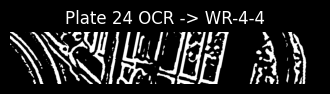


--- Plate 25 ---
  Plate 25 | pytesseract | --psm 7 | orig --> 'H\n\x0c'
  Plate 25 | pytesseract | --psm 7 | inv --> 'L\n\x0c'
  Plate 25 | pytesseract | --psm 6 | orig --> 'H\n\x0c'
  Plate 25 | pytesseract | --psm 6 | inv --> 'L\n\x0c'
  Plate 25 | pytesseract | --psm 8 | orig --> 'NRS\n\x0c'
  Plate 25 | pytesseract | --psm 8 | inv --> 'USSSQFS\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['7', 'J', '7']
  >> 선택된 후보: 7 -> normalized: 7-7-7 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


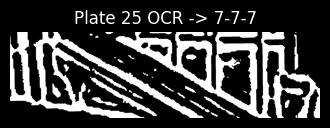


--- Plate 26 ---
  Plate 26 | pytesseract | --psm 7 | orig --> 'TY\n\x0c'
  Plate 26 | pytesseract | --psm 7 | inv --> 'HEN\n\x0c'
  Plate 26 | pytesseract | --psm 6 | orig --> 'TY\n\x0c'
  Plate 26 | pytesseract | --psm 6 | inv --> 'HEN\n\x0c'
  Plate 26 | pytesseract | --psm 8 | orig --> 'HY4\n\x0c'
  Plate 26 | pytesseract | --psm 8 | inv --> 'HY4\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['7']
  >> 선택된 후보: HY4 -> normalized: HY-4-4 (total_score=33)
     detail: base=8, pattern=25, src=--psm 8/orig


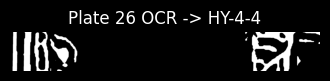


--- Plate 27 ---
  Plate 27 | pytesseract | --psm 7 | orig --> '\x0c'
  Plate 27 | pytesseract | --psm 7 | inv --> '\x0c'
  Plate 27 | pytesseract | --psm 6 | orig --> 'STN\nLN 7 HN\nANN 4 WO\n\x0c'
  Plate 27 | pytesseract | --psm 6 | inv --> 'HERSELF\nPPAR T\nNNN F WO\n\x0c'
  Plate 27 | pytesseract | --psm 8 | orig --> 'ST\n\x0c'
  Plate 27 | pytesseract | --psm 8 | inv --> 'SHERREETEP\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['X', 'R', '487']
  >> 선택된 후보: STNLN7HNANN4WO -> normalized: ST-74-74 (total_score=26)
     detail: base=24, pattern=2, src=--psm 6/orig


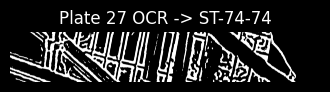


--- Plate 28 ---
  Plate 28 | pytesseract | --psm 7 | orig --> '22\n\x0c'
  Plate 28 | pytesseract | --psm 7 | inv --> 'WOWEINBSIN\n\x0c'
  Plate 28 | pytesseract | --psm 6 | orig --> '22\n\x0c'
  Plate 28 | pytesseract | --psm 6 | inv --> 'WOWEINBSIN\n\x0c'
  Plate 28 | pytesseract | --psm 8 | orig --> 'WOWEIPNBNSN\n\x0c'
  Plate 28 | pytesseract | --psm 8 | inv --> 'WORE\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['JDEpky ~A*p']
  >> 선택된 후보: 22 -> normalized: 22-22-22 (total_score=2)
     detail: base=12, pattern=-10, src=--psm 7/orig


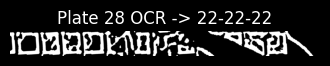


--- Plate 29 ---
  Plate 29 | pytesseract | --psm 7 | orig --> 'A2A2O2N\n\x0c'
  Plate 29 | pytesseract | --psm 7 | inv --> 'JOORRORARCESSIN\n\x0c'
  Plate 29 | pytesseract | --psm 6 | orig --> 'A2A2O2N\n\x0c'
  Plate 29 | pytesseract | --psm 6 | inv --> 'JOORRORARCESSIN\n\x0c'
  Plate 29 | pytesseract | --psm 8 | orig --> 'A2A2O2N\n\x0c'
  Plate 29 | pytesseract | --psm 8 | inv --> 'JOORRORARCESSIN\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['3=', 'JPD1226254', 'Z@']
  >> 선택된 후보: JPD1226254 -> normalized: JP-12-6254 (total_score=190)
     detail: base=45, pattern=145, src=easyocr/ext


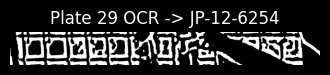


--- Plate 30 ---
  Plate 30 | pytesseract | --psm 7 | orig --> '518HSN\n\x0c'
  Plate 30 | pytesseract | --psm 7 | inv --> 'TICTEUSIOIAS\n\x0c'
  Plate 30 | pytesseract | --psm 6 | orig --> '518HSN\n\x0c'
  Plate 30 | pytesseract | --psm 6 | inv --> 'TICTEUSIOIAS\n\x0c'
  Plate 30 | pytesseract | --psm 8 | orig --> '518HSN\n\x0c'
  Plate 30 | pytesseract | --psm 8 | inv --> 'TICTEUSIOIAS\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['TPMITAXXWUI', 'J', '3']
  >> 선택된 후보: 518HSN -> normalized: HS-51-8 (total_score=28)
     detail: base=21, pattern=7, src=--psm 7/orig


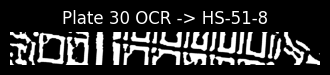


--- Plate 31 ---
  Plate 31 | pytesseract | --psm 7 | orig --> 'ASAT\n\x0c'
  Plate 31 | pytesseract | --psm 7 | inv --> 'PTETIGILIN\n\x0c'
  Plate 31 | pytesseract | --psm 6 | orig --> 'ASAT\n\x0c'
  Plate 31 | pytesseract | --psm 6 | inv --> 'PTETIGILIN\n\x0c'
  Plate 31 | pytesseract | --psm 8 | orig --> 'ASAT\n\x0c'
  Plate 31 | pytesseract | --psm 8 | inv --> 'PTETIGILIN\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['Uoaa', '1h']
  >> 선택된 후보: PTETIGILIN -> normalized: PT-- (total_score=-7)
     detail: base=10, pattern=-17, src=--psm 7/inv


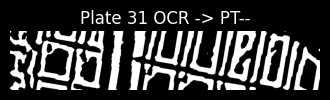


--- Plate 32 ---
  Plate 32 | pytesseract | --psm 7 | orig --> '1OTS\n\x0c'
  Plate 32 | pytesseract | --psm 7 | inv --> 'HOHSSIO\n\x0c'
  Plate 32 | pytesseract | --psm 6 | orig --> '1OTS\n\x0c'
  Plate 32 | pytesseract | --psm 6 | inv --> 'HOHSSIO\n\x0c'
  Plate 32 | pytesseract | --psm 8 | orig --> '1OTS\n\x0c'
  Plate 32 | pytesseract | --psm 8 | inv --> 'HOHSSIO\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['Qiik', 'Q']
  >> 선택된 후보: HOHSSIO -> normalized: HO-- (total_score=-10)
     detail: base=7, pattern=-17, src=--psm 7/inv


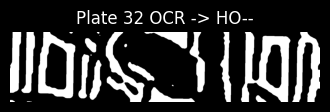


--- Plate 33 ---
  Plate 33 | pytesseract | --psm 7 | orig --> 'AOIAVOIDIBIINECAAI\n\x0c'
  Plate 33 | pytesseract | --psm 7 | inv --> 'AIOIVDIDIBINECAAIC\n\x0c'
  Plate 33 | pytesseract | --psm 6 | orig --> 'AOIAVOIDIBIINECAAI\n\x0c'
  Plate 33 | pytesseract | --psm 6 | inv --> 'AIOIVDIDIBINECAAIC\n\x0c'
  Plate 33 | pytesseract | --psm 8 | orig --> 'AOIAVOIDIBIINECAAI\n\x0c'
  Plate 33 | pytesseract | --psm 8 | inv --> 'AIOIVDIDIBINECAAIC\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['Idil', 'IDipipidldic', '0']
  >> 선택된 후보: 0 -> normalized: 0-0-0 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


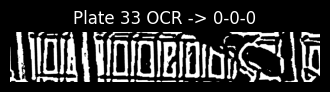


--- Plate 34 ---
  Plate 34 | pytesseract | --psm 7 | orig --> 'TATTATAATATTAY\n\x0c'
  Plate 34 | pytesseract | --psm 7 | inv --> 'WOIOIDIDICIL\n\x0c'
  Plate 34 | pytesseract | --psm 6 | orig --> 'TATTATAATATTAY\n\x0c'
  Plate 34 | pytesseract | --psm 6 | inv --> 'WOIOIDIDICIL\n\x0c'
  Plate 34 | pytesseract | --psm 8 | orig --> 'TATTAANTAATATTAY\n\x0c'
  Plate 34 | pytesseract | --psm 8 | inv --> 'WOODS\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['6', 'unld', '@']
  >> 선택된 후보: 6 -> normalized: 6-6-6 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


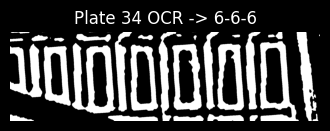


--- Plate 35 ---
  Plate 35 | pytesseract | --psm 7 | orig --> '\x0c'
  Plate 35 | pytesseract | --psm 7 | inv --> '\x0c'
  Plate 35 | pytesseract | --psm 6 | orig --> '- -- -O\n---- NAS\n4-7\n- RS LZ S\nSP NN PP M S\nSSS SSS SERRONONEHAON\nRUE SS FE IE SS S MS AR 2\nAY S-G\nSS 7 CY ST C RGN WW\nAEN SCS - A\nD SSS S SS\nST SSS ET SS SST SAS Y O 5 STEN 4 HA Y\nSS RR N ITE - 5 TY C 59 F -\nFALE HH TTTT SS\nTMG SST SS M WA\n- N 2 Y\nA HA\n\x0c'
  Plate 35 | pytesseract | --psm 6 | inv --> '-- 7\n3---- A\n- 4-7 2\nSSY CO LZ S\nC S 5 4\nSYSS SSS SEEBNRSANEAN\nQT - WN AS SE PA QT DD\nN4 CES -\nSS - Y SS C A RE R\nSS ANE SCS - OS\nSS D SSS S SS S\nSSS 0 4 TS SST SAS 4 STEN 4 1 HA Y\nES PR FA - 4 - SS 559 - 5\nARS HT L UN SS\nTMG SSS IS UO OOP\n- N IPI 3\nA PY HATED S\n\x0c'
  Plate 35 | pytesseract | --psm 8 | orig --> 'SS\n\x0c'
  Plate 35 | pytesseract | --psm 8 | inv --> 'SES\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  >> 선택된 후보: -73-A-4-72SSYCOLZSCS54SYSSSSSSEEBNRSANEANQT-WNASSEPAQTDDN4CES-SS-YSSCARERSSANESCS-OSSSDSSSSSSSSSS04TSSSTSAS4STEN41HAYESPRFA-4-SS559-5ARSHTLUNSSTMGSSSISUOOOP-NIPI3APYHATEDS -> normalized: 73--5953 (total_score=417)
     detail: base=266, pattern=151, src=--psm 6/inv


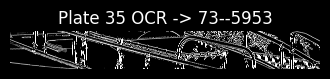


--- Plate 36 ---
  Plate 36 | pytesseract | --psm 7 | orig --> 'O\n\x0c'
  Plate 36 | pytesseract | --psm 7 | inv --> '2SSR\n\x0c'
  Plate 36 | pytesseract | --psm 6 | orig --> '\x0c'
  Plate 36 | pytesseract | --psm 6 | inv --> '\x0c'
  Plate 36 | pytesseract | --psm 8 | orig --> 'O\n\x0c'
  Plate 36 | pytesseract | --psm 8 | inv --> '2SSR\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['$e', '0', 'Aa', 'P']
  >> 선택된 후보: 0 -> normalized: 0-0-0 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


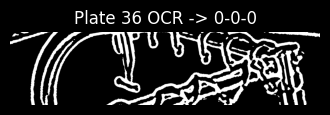


--- Plate 37 ---
  Plate 37 | pytesseract | --psm 7 | orig --> '\x0c'
  Plate 37 | pytesseract | --psm 7 | inv --> '\x0c'
  Plate 37 | pytesseract | --psm 6 | orig --> 'OA - Y\n\x0c'
  Plate 37 | pytesseract | --psm 6 | inv --> 'EWASS Y\n\x0c'
  Plate 37 | pytesseract | --psm 8 | orig --> 'SNL\n\x0c'
  Plate 37 | pytesseract | --psm 8 | inv --> 'ISN\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['TGk;']
  >> 선택된 후보: OA-Y -> normalized: OA-- (total_score=7)
     detail: base=4, pattern=3, src=--psm 6/orig


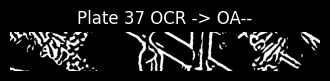


--- Plate 38 ---
  Plate 38 | pytesseract | --psm 7 | orig --> 'CG\n\x0c'
  Plate 38 | pytesseract | --psm 7 | inv --> 'NSCLBA\n\x0c'
  Plate 38 | pytesseract | --psm 6 | orig --> 'CG\n\x0c'
  Plate 38 | pytesseract | --psm 6 | inv --> 'NSCLBA\n\x0c'
  Plate 38 | pytesseract | --psm 8 | orig --> 'CG\n\x0c'
  Plate 38 | pytesseract | --psm 8 | inv --> 'NSCLBA\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['TL']
  >> 선택된 후보: NSCLBA -> normalized: NS-- (total_score=-11)
     detail: base=6, pattern=-17, src=--psm 7/inv


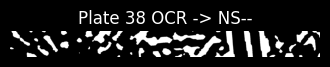


--- Plate 39 ---
  Plate 39 | pytesseract | --psm 7 | orig --> 'UNNSEEOARGANRASS\n\x0c'
  Plate 39 | pytesseract | --psm 7 | inv --> 'CENSORS\n\x0c'
  Plate 39 | pytesseract | --psm 6 | orig --> 'UNNSEEOARGANRASS\n\x0c'
  Plate 39 | pytesseract | --psm 6 | inv --> 'CENSORS\n\x0c'
  Plate 39 | pytesseract | --psm 8 | orig --> 'UNNSEEOARGANRASS\n\x0c'
  Plate 39 | pytesseract | --psm 8 | inv --> 'CENSORS\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  >> 선택된 후보: UNNSEEOARGANRASS -> normalized: UN-- (total_score=-1)
     detail: base=16, pattern=-17, src=--psm 7/orig


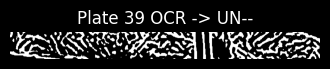


--- Plate 40 ---
  Plate 40 | pytesseract | --psm 7 | orig --> 'CSC\n\x0c'
  Plate 40 | pytesseract | --psm 7 | inv --> 'SENATSRNO\n\x0c'
  Plate 40 | pytesseract | --psm 6 | orig --> 'CSC\n\x0c'
  Plate 40 | pytesseract | --psm 6 | inv --> 'SENATSRNO\n\x0c'
  Plate 40 | pytesseract | --psm 8 | orig --> 'CSC\n\x0c'
  Plate 40 | pytesseract | --psm 8 | inv --> 'SENATSRNO\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  >> 선택된 후보: SENATSRNO -> normalized: SE-- (total_score=-8)
     detail: base=9, pattern=-17, src=--psm 7/inv


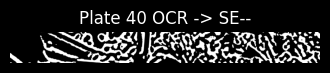


--- Plate 41 ---
  Plate 41 | pytesseract | --psm 7 | orig --> 'UERAVANNDSP\n\x0c'
  Plate 41 | pytesseract | --psm 7 | inv --> 'UERAVANNDSP\n\x0c'
  Plate 41 | pytesseract | --psm 6 | orig --> 'EEUVES EN SG NS AG\n\x0c'
  Plate 41 | pytesseract | --psm 6 | inv --> 'RENAE ANS SG NS OP\n\x0c'
  Plate 41 | pytesseract | --psm 8 | orig --> 'UERAVANNDSP\n\x0c'
  Plate 41 | pytesseract | --psm 8 | inv --> 'UERAVANNDSP\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['o']
  >> 선택된 후보: EEUVESENSGNSAG -> normalized: EE-- (total_score=-3)
     detail: base=14, pattern=-17, src=--psm 6/orig


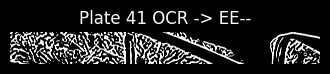


--- Plate 42 ---
  Plate 42 | pytesseract | --psm 7 | orig --> 'SRG\n\x0c'
  Plate 42 | pytesseract | --psm 7 | inv --> 'ALA\n\x0c'
  Plate 42 | pytesseract | --psm 6 | orig --> 'SRG\n\x0c'
  Plate 42 | pytesseract | --psm 6 | inv --> 'ALA\n\x0c'
  Plate 42 | pytesseract | --psm 8 | orig --> 'SG\n\x0c'
  Plate 42 | pytesseract | --psm 8 | inv --> 'ALN\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['L']
  >> 선택된 후보: SRG -> normalized: SR-- (total_score=-17)
     detail: base=3, pattern=-20, src=--psm 7/orig


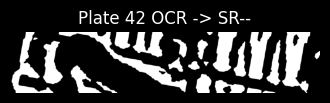


--- Plate 43 ---
  Plate 43 | pytesseract | --psm 7 | orig --> '234 YI-\n\x0c'
  Plate 43 | pytesseract | --psm 7 | inv --> 'SSITDBS VI-\n\x0c'
  Plate 43 | pytesseract | --psm 6 | orig --> '234 YI-\n\x0c'
  Plate 43 | pytesseract | --psm 6 | inv --> 'SSITDBS VI-\n\x0c'
  Plate 43 | pytesseract | --psm 8 | orig --> 'OSSITDBSNILS\n\x0c'
  Plate 43 | pytesseract | --psm 8 | inv --> 'SSITDABENLS\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['~) 2', '13', '4']
  >> 선택된 후보: 234YI- -> normalized: YI-23-4 (total_score=48)
     detail: base=21, pattern=27, src=--psm 7/orig


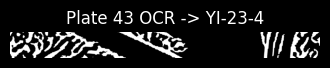


--- Plate 44 ---
  Plate 44 | pytesseract | --psm 7 | orig --> 'CHT 1\n\x0c'
  Plate 44 | pytesseract | --psm 7 | inv --> 'CHT NN\n\x0c'
  Plate 44 | pytesseract | --psm 6 | orig --> 'LS A\n\x0c'
  Plate 44 | pytesseract | --psm 6 | inv --> 'WBU SS\n\x0c'
  Plate 44 | pytesseract | --psm 8 | orig --> 'YA\n\x0c'
  Plate 44 | pytesseract | --psm 8 | inv --> 'NO\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['C ', '7a']
  >> 선택된 후보: CHT1 -> normalized: CH-1-1 (total_score=6)
     detail: base=9, pattern=-3, src=--psm 7/orig


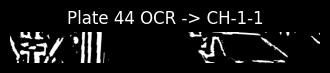


--- Plate 45 ---
  Plate 45 | pytesseract | --psm 7 | orig --> 'NWASCS2T14PLEEW\n\x0c'
  Plate 45 | pytesseract | --psm 7 | inv --> 'NWASCHSAT1PLEEW\n\x0c'
  Plate 45 | pytesseract | --psm 6 | orig --> 'NWASCS2T14PLEEW\n\x0c'
  Plate 45 | pytesseract | --psm 6 | inv --> 'NWASCHSAT1PLEEW\n\x0c'
  Plate 45 | pytesseract | --psm 8 | orig --> 'AYANAY2LAOT\n\x0c'
  Plate 45 | pytesseract | --psm 8 | inv --> 'NWAICS1PLSY\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['08', 'JY^T']
  >> 선택된 후보: NWASCS2T14PLEEW -> normalized: NW-21-4 (total_score=42)
     detail: base=30, pattern=12, src=--psm 7/orig


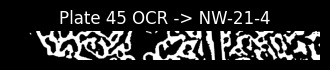


--- Plate 46 ---
  Plate 46 | pytesseract | --psm 7 | orig --> 'WANVWNREVANNR\n\x0c'
  Plate 46 | pytesseract | --psm 7 | inv --> 'VANVSWNREVANNR\n\x0c'
  Plate 46 | pytesseract | --psm 6 | orig --> 'WANVWNREVANNR\n\x0c'
  Plate 46 | pytesseract | --psm 6 | inv --> 'VANVSWNREVANNR\n\x0c'
  Plate 46 | pytesseract | --psm 8 | orig --> 'ANYARRNAVGR\n\x0c'
  Plate 46 | pytesseract | --psm 8 | inv --> 'AMTKVUYUTIN\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ["AUI; #PA ' #PVMIVpzo,"]
  >> 선택된 후보: VANVSWNREVANNR -> normalized: VA-- (total_score=-3)
     detail: base=14, pattern=-17, src=--psm 7/inv


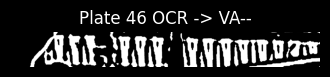


--- Plate 47 ---
  Plate 47 | pytesseract | --psm 7 | orig --> 'AAHEHANMAILS\n\x0c'
  Plate 47 | pytesseract | --psm 7 | inv --> 'ANESTATWM\n\x0c'
  Plate 47 | pytesseract | --psm 6 | orig --> 'ANESTAT\nUN\n\x0c'
  Plate 47 | pytesseract | --psm 6 | inv --> 'ANESTAT\nURN\n\x0c'
  Plate 47 | pytesseract | --psm 8 | orig --> 'AAHEHANMAILS\n\x0c'
  Plate 47 | pytesseract | --psm 8 | inv --> 'ANESTATWM\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['C', 'QUN', '20N7', 'V']
  >> 선택된 후보: 20N7 -> normalized: N-20-7 (total_score=46)
     detail: base=19, pattern=27, src=easyocr/ext


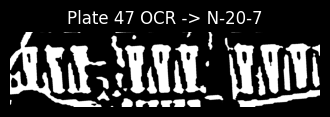


--- Plate 48 ---
  Plate 48 | pytesseract | --psm 7 | orig --> '42P\n\x0c'
  Plate 48 | pytesseract | --psm 7 | inv --> 'TLVAESO1\n\x0c'
  Plate 48 | pytesseract | --psm 6 | orig --> '42P\n\x0c'
  Plate 48 | pytesseract | --psm 6 | inv --> 'TLVAESO1\n\x0c'
  Plate 48 | pytesseract | --psm 8 | orig --> '42P\n\x0c'
  Plate 48 | pytesseract | --psm 8 | inv --> 'TLVAESO1\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  EasyOCR outputs: ['H{', 'VN']
  >> 선택된 후보: TLVAESO1 -> normalized: TL-1-1 (total_score=10)
     detail: base=13, pattern=-3, src=--psm 7/inv


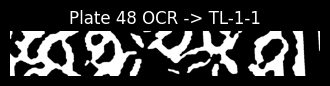


--- Plate 49 ---
  Plate 49 | pytesseract | --psm 7 | orig --> 'MONENSNAENS\n\x0c'
  Plate 49 | pytesseract | --psm 7 | inv --> 'MINENSNAENS\n\x0c'
  Plate 49 | pytesseract | --psm 6 | orig --> 'MONENSNAENS\n\x0c'
  Plate 49 | pytesseract | --psm 6 | inv --> 'MINENSNAENS\n\x0c'
  Plate 49 | pytesseract | --psm 8 | orig --> 'MANENSVAEENS\n\x0c'
  Plate 49 | pytesseract | --psm 8 | inv --> 'MANNA\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['3']
  >> 선택된 후보: 3 -> normalized: 3-3-3 (total_score=11)
     detail: base=6, pattern=5, src=easyocr/ext


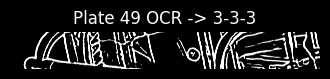


--- Plate 50 ---
  Plate 50 | pytesseract | --psm 7 | orig --> '\x0c'
  Plate 50 | pytesseract | --psm 7 | inv --> '\x0c'
  Plate 50 | pytesseract | --psm 6 | orig --> 'ASP\nA\n\x0c'
  Plate 50 | pytesseract | --psm 6 | inv --> 'ASP\nNS 4H\n\x0c'
  Plate 50 | pytesseract | --psm 8 | orig --> 'B3\n\x0c'
  Plate 50 | pytesseract | --psm 8 | inv --> 'NRG\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['98', '3', '33']
  >> 선택된 후보: ASPNS4H -> normalized: AS-4-4 (total_score=13)
     detail: base=12, pattern=1, src=--psm 6/inv


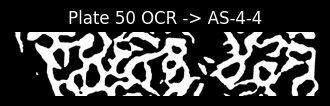


--- Plate 51 ---
  Plate 51 | pytesseract | --psm 7 | orig --> 'ESTACRIEAOC\n\x0c'
  Plate 51 | pytesseract | --psm 7 | inv --> '1OSIINS2I\n\x0c'
  Plate 51 | pytesseract | --psm 6 | orig --> 'TYSTACROA\nAPEINATS AXONAL SO\n\x0c'
  Plate 51 | pytesseract | --psm 6 | inv --> '19S\n0INY2 NS08 TE\n\x0c'
  Plate 51 | pytesseract | --psm 8 | orig --> 'ESTACRIEAOC\n\x0c'
  Plate 51 | pytesseract | --psm 8 | inv --> '1OSIINS2I\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['i']
  >> 선택된 후보: 19S0INY2NS08TE -> normalized: SI-20-1908 (total_score=118)
     detail: base=44, pattern=74, src=--psm 6/inv


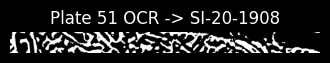


--- Plate 52 ---
  Plate 52 | pytesseract | --psm 7 | orig --> '\x0c'
  Plate 52 | pytesseract | --psm 7 | inv --> '\x0c'
  Plate 52 | pytesseract | --psm 6 | orig --> '3\n\x0c'
  Plate 52 | pytesseract | --psm 6 | inv --> '24 1\n\x0c'
  Plate 52 | pytesseract | --psm 8 | orig --> 'MS55S\n\x0c'
  Plate 52 | pytesseract | --psm 8 | inv --> 'GER\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['3=', '2', '78']
  >> 선택된 후보: MS55S -> normalized: MS-55-55 (total_score=67)
     detail: base=15, pattern=52, src=--psm 8/orig


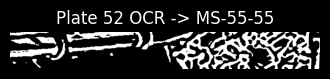


--- Plate 53 ---
  Plate 53 | pytesseract | --psm 7 | orig --> 'NBLONSTNE\n\x0c'
  Plate 53 | pytesseract | --psm 7 | inv --> 'FSW\n\x0c'
  Plate 53 | pytesseract | --psm 6 | orig --> '7\nNBLONSTNE\nSPALYP4\n\x0c'
  Plate 53 | pytesseract | --psm 6 | inv --> '- NS\nFSW\nYANTON\n\x0c'
  Plate 53 | pytesseract | --psm 8 | orig --> 'NBLONSTNE\n\x0c'
  Plate 53 | pytesseract | --psm 8 | inv --> 'FSW\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['3', 'W']
  >> 선택된 후보: -NSFSWYANTON -> normalized: NS-- (total_score=15)
     detail: base=12, pattern=3, src=--psm 6/inv


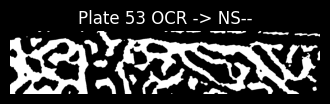


--- Plate 54 ---
  Plate 54 | pytesseract | --psm 7 | orig --> 'V71LA\n\x0c'
  Plate 54 | pytesseract | --psm 7 | inv --> 'AY2311F\n\x0c'
  Plate 54 | pytesseract | --psm 6 | orig --> 'V71LA\n\x0c'
  Plate 54 | pytesseract | --psm 6 | inv --> 'AY2311F\n\x0c'
  Plate 54 | pytesseract | --psm 8 | orig --> 'BV\n\x0c'
  Plate 54 | pytesseract | --psm 8 | inv --> 'AYF2311E\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['U', '6p']
  >> 선택된 후보: AY2311F -> normalized: AY-23-11 (total_score=176)
     detail: base=27, pattern=149, src=--psm 7/inv


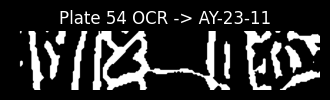


--- Plate 55 ---
  Plate 55 | pytesseract | --psm 7 | orig --> 'TYEPYZVO\n\x0c'
  Plate 55 | pytesseract | --psm 7 | inv --> 'TY-FYZVO\n\x0c'
  Plate 55 | pytesseract | --psm 6 | orig --> 'L\nCL\nO\n\x0c'
  Plate 55 | pytesseract | --psm 6 | inv --> 'TTD L\nCL\nSZ\nO\n\x0c'
  Plate 55 | pytesseract | --psm 8 | orig --> 'TYEPYZVO\n\x0c'
  Plate 55 | pytesseract | --psm 8 | inv --> 'TY-FYZVO\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ['J', '7ar?', '6c']
  >> 선택된 후보: TY-FYZVO -> normalized: TY-- (total_score=11)
     detail: base=8, pattern=3, src=--psm 7/inv


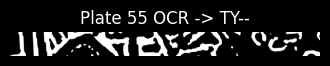


--- Plate 56 ---
  Plate 56 | pytesseract | --psm 7 | orig --> 'ONV-2-O-\n\x0c'
  Plate 56 | pytesseract | --psm 7 | inv --> 'ONV-2-4-\n\x0c'
  Plate 56 | pytesseract | --psm 6 | orig --> 'ONV-2-O-\n\x0c'
  Plate 56 | pytesseract | --psm 6 | inv --> 'ONV-2-4-\n\x0c'
  Plate 56 | pytesseract | --psm 8 | orig --> 'ONV-2-O-\n\x0c'
  Plate 56 | pytesseract | --psm 8 | inv --> 'ONV-2-4-\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  EasyOCR outputs: ["Mz'", 'Onl', '7']
  >> 선택된 후보: ONV-2-4- -> normalized: ON-2-4 (total_score=64)
     detail: base=18, pattern=46, src=--psm 7/inv


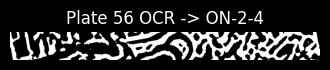


--- Plate 57 ---
  Plate 57 | pytesseract | --psm 7 | orig --> 'A MA 7 S WN\n\x0c'
  Plate 57 | pytesseract | --psm 7 | inv --> 'SM N MA 7 SET WN\n\x0c'
  Plate 57 | pytesseract | --psm 6 | orig --> 'SOOS\nVI 4 - BS 5\nT\n\n7 P 7 CN S\n\x0c'
  Plate 57 | pytesseract | --psm 6 | inv --> 'I OT S2FCHESEEO\nLT V 4 YL 1B BS\n\nO T\n\n- A 9X - SS\n\x0c'
  Plate 57 | pytesseract | --psm 8 | orig --> '4\n\x0c'
  Plate 57 | pytesseract | --psm 8 | inv --> 'OIDASSM\n\x0c'


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


  PaddleOCR parsing fallback failed: tuple index out of range
  >> 선택된 후보: SOOSVI4-BS5T7P7CNS -> normalized: SO-45-77 (total_score=63)
     detail: base=38, pattern=25, src=--psm 6/orig


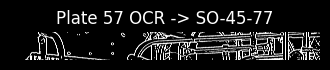


--- Plate 58 ---
  Plate 58 | pytesseract | --psm 7 | orig --> 'ASUVLAK\n\x0c'
  Plate 58 | pytesseract | --psm 7 | inv --> 'ASUVLAK\n\x0c'
  Plate 58 | pytesseract | --psm 6 | orig --> 'ASUVLAK\n\x0c'
  Plate 58 | pytesseract | --psm 6 | inv --> 'ASUVLAK\n\x0c'
  Plate 58 | pytesseract | --psm 8 | orig --> 'ASUVLAK\n\x0c'
  Plate 58 | pytesseract | --psm 8 | inv --> 'ASUVLAK\n\x0c'
  PaddleOCR parsing fallback failed: tuple index out of range


/tmp/ipython-input-2294181140.py:285: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin, cls=False)
/tmp/ipython-input-2294181140.py:304: DeprecationWarning: Please use `predict` instead.
  res = paddle_ocr.ocr(patch_bin)


KeyboardInterrupt: 

In [16]:
# full_plate_ocr_pipeline.py
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract

# ------------------ 설정 ------------------
UPSCALE_OCR = 7.0            # OCR 전에 패치를 키울 배율 (권장 1.6~2.5)
base_cfg = r'--oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'
psm_list = ['--psm 7', '--psm 6', '--psm 8']

# 외부 OCR 사용 플래그 (설치되어 있으면 자동으로 사용)
USE_PADDLE = True
USE_EASY = True

CONF_DIGIT_WEIGHT = 5    # 숫자 가중치 (패턴 점수에 합산)
# -------------------------------------------

# ---------------- External OCR 초기화 ----------------
paddle_ocr = None
easy_reader = None

if USE_PADDLE:
    try:
        from paddleocr import PaddleOCR
        paddle_ocr = PaddleOCR(use_angle_cls=False, lang='en')
        print("PaddleOCR initialized.")
    except Exception as e:
        paddle_ocr = None
        print("PaddleOCR not available:", e)

if USE_EASY:
    try:
        import easyocr
        easy_reader = easyocr.Reader(['en'], gpu=False)
        print("EasyOCR initialized.")
    except Exception as e:
        easy_reader = None
        print("EasyOCR not available:", e)
# ------------------------------------------------------

# ---------------- Utility functions -------------------
def normalize_preserve_numeric_agency(s, seq_target_len=4):
    """
    정규화: AG-YY-SEQ 형태로 반환.
    - s: 정리된 문자열 (대문자, 숫자, 하이픈만 포함 권장)
    - seq_target_len: 일렬번호 자리수(기본 4)
    동작:
      1) 하이픈이 있는 경우 우선 분해해서 agency/year/seq 추출 시도
      2) 없으면 문자-숫자 위치 규칙(좌->우)으로 추정
      3) 최종적으로 반드시 'AG-YY-SEQ' 형식(하이픈 포함)으로 반환.
         부족한 값은 빈 문자열 대신 ''로 두지만 하이픈 위치는 항상 지키도록 포맷화.
    """
    if not s:
        return ''

    raw = re.sub(r'[^A-Za-z0-9\-]', '', s).upper()
    if raw == '':
        return ''

    # 하이픈 기반 우선
    if '-' in raw:
        parts = [p for p in raw.split('-') if p != '']
        if len(parts) >= 3:
            agency = parts[0][:2].upper()
            year = re.sub(r'[^0-9]', '', parts[1])[:2]
            seq_part = ''.join(parts[2:])
            seq_digits = re.sub(r'[^0-9]', '', seq_part)
            if len(seq_digits) > seq_target_len:
                seq_digits = seq_digits[-seq_target_len:]
            return f"{agency}-{year}-{seq_digits}"
        # else fallthrough

    clean = raw.replace('-', '')
    chars = list(clean)
    n = len(chars)

    # agency: 좌->우에서 up to 2 letters 우선으로 찾음, 없으면 first 2 chars 사용
    agency = ''
    used_idx = set()
    letter_count = 0
    for idx, ch in enumerate(chars):
        if ch.isalpha():
            agency += ch
            used_idx.add(idx)
            letter_count += 1
            if letter_count == 2:
                break
    if letter_count == 0:
        agency = ''.join(chars[:2]) if n >= 2 else ''.join(chars)
        for i in range(min(2, n)):
            used_idx.add(i)
    agency = agency[:2]

    # year: agency 뒤에서부터 숫자 2개 찾기, 못찾으면 전체에서 찾음
    year = ''
    start_idx = max(used_idx) + 1 if used_idx else 0
    digits_found = []
    digit_positions = []
    for idx in range(start_idx, n):
        if chars[idx].isdigit():
            digits_found.append(chars[idx]); digit_positions.append(idx)
            if len(digits_found) == 2:
                break
    if len(digits_found) < 2:
        digits_found = []; digit_positions = []
        for idx in range(n):
            if chars[idx].isdigit():
                digits_found.append(chars[idx]); digit_positions.append(idx)
                if len(digits_found) == 2:
                    break
    if digits_found:
        year = ''.join(digits_found[:2])
        for p in digit_positions[:2]:
            used_idx.add(p)

    # seq: 남은 숫자들 중 오른쪽 끝 seq_target_len 숫자 선택
    rem_digits = []
    for idx in range(n):
        if chars[idx].isdigit() and idx not in used_idx:
            rem_digits.append(chars[idx])
    if len(rem_digits) == 0:
        all_digits = [c for c in chars if c.isdigit()]
        rem = ''.join(all_digits[-seq_target_len:]) if all_digits else ''
    else:
        rem = ''.join(rem_digits)
        if len(rem) > seq_target_len:
            rem = rem[-seq_target_len:]
    seq = rem

    return f"{agency}-{year}-{seq}"

def add_external_ocr_candidates(texts, source_name, raw_candidates):
    """외부 OCR 텍스트들을 cleaned 후보로 변환해 raw_candidates에 추가."""
    for t in texts:
        if not t:
            continue
        cleaned = re.sub(r'[^A-Za-z0-9\-]', '', str(t)).upper()
        cleaned = re.sub(r'-{2,}', '-', cleaned)
        if cleaned:
            raw_candidates.append({'cleaned': cleaned, 'raw': t, 'psm': source_name, 'variant': 'ext'})

def evaluate_candidate_no_agency_constraint(cleaned):
    """
    패턴 기반 점수 계산 (기관 화이트리스트 없이)
    cleaned: A-Z0-9- 만 포함된 문자열
    반환: (score, detail_dict)
    """
    detail = {}
    s = cleaned
    n_total = len(s)
    n_digits = sum(ch.isdigit() for ch in s)
    n_letters = sum(ch.isalpha() for ch in s)
    n_hyphens = s.count('-')

    # 분해 시도
    parts = s.split('-')
    agency = ''
    year = ''
    seq = ''
    if len(parts) >= 3:
        agency = parts[0]
        year = parts[1]
        seq = ''.join(parts[2:])
    else:
        m = re.search(r'([A-Z]{1,2})[- ]?([0-9]{2}|[0-9A-Z]{2})[- ]?([0-9A-Z]{3,8})', s)
        if m:
            agency = m.group(1)
            year = m.group(2)
            seq = m.group(3)
        else:
            if n_total >= 2:
                agency = s[:2]
            if n_total >= 4:
                seq = s[-4:]

    agency = (agency or '').upper()
    year = (year or '').upper()
    seq = (seq or '').upper()

    score = 0
    # agency: 알파벳 1~2이면 소량 보너스, 숫자 포함하면 소량 벌점
    if re.fullmatch(r'[A-Z]{1,2}', agency):
        score += 20; detail['agency_alpha_small'] = 20
    else:
        if any(ch.isdigit() for ch in agency) and agency:
            score -= 20; detail['agency_digit_penalty'] = -20

    # year: 정확히 2자리 숫자이면 큰 보너스
    if re.fullmatch(r'\d{2}', year):
        score += 80; detail['year_ok'] = 80
    else:
        if year:
            digit_prop_year = sum(c.isdigit() for c in year) / (len(year) + 1e-9)
            add = int(15 * digit_prop_year)
            score += add; detail['year_partial'] = add

    # seq: 4자리 숫자 우대
    if re.fullmatch(r'\d{4}', seq):
        score += 200; detail['seq_ok'] = 200
    elif re.fullmatch(r'\d{3,6}', seq):
        score += 80; detail['seq_ok_loose'] = 80
    else:
        if seq:
            digit_prop_seq = sum(c.isdigit() for c in seq) / (len(seq) + 1e-9)
            add = int(40 * digit_prop_seq)
            score += add; detail['seq_partial'] = add

    if n_hyphens >= 1:
        score += 20; detail['hyphen_bonus'] = 20

    digit_prop_overall = n_digits / (n_total + 1e-9) if n_total > 0 else 0
    if digit_prop_overall < 0.25:
        score -= 40; detail['low_digit_prop_penalty'] = -40

    if 4 <= n_total <= 16:
        score += 3; detail['len_ok_small'] = 3
    elif n_total > 16:
        score -= 8; detail['len_too_long'] = -8

    score += CONF_DIGIT_WEIGHT * n_digits
    detail['digit_weight'] = CONF_DIGIT_WEIGHT * n_digits

    return score, detail
# ------------------------------------------------------

# ---------------- main OCR loop ----------------
if 'plate_imgs' not in globals():
    raise RuntimeError("plate_imgs 변수가 없습니다. 이전 단계에서 plate_imgs를 생성하세요.")

if not hasattr(plate_imgs, '__len__') or len(plate_imgs) == 0:
    print("plate_imgs가 비어있습니다. OCR 할 항목이 없습니다.")
else:
    plate_chars = []
    best_plate_idx = -1
    best_plate_score = -1e9

    for i, raw_patch in enumerate(plate_imgs):
        print(f"\n--- Plate {i} ---")
        patch = raw_patch.copy()
        if patch is None or patch.size == 0:
            print("  (빈 패치) 건너뜁니다.")
            plate_chars.append('')
            continue

        if patch.ndim == 3:
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        patch = patch.astype('uint8')

        # upscaling + binarize
        if UPSCALE_OCR != 1.0:
            patch = cv2.resize(patch, (0,0), fx=UPSCALE_OCR, fy=UPSCALE_OCR, interpolation=cv2.INTER_CUBIC)
        _, patch_bin = cv2.threshold(patch, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # slight closing to connect strokes
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
        patch_bin = cv2.morphologyEx(patch_bin, cv2.MORPH_CLOSE, kernel, iterations=1)

        # 1) pytesseract candidates
        variants = {'orig': patch_bin, 'inv': 255 - patch_bin}
        raw_candidates = []
        for psm in psm_list:
            for vname, vimg in variants.items():
                try:
                    pil = Image.fromarray(vimg)
                    cfg = base_cfg + ' ' + psm
                    raw = pytesseract.image_to_string(pil, lang='eng', config=cfg)
                except Exception as e:
                    raw = ''
                    print(f"  [ERROR pytesseract] psm={psm} variant={vname}: {e}")
                print(f"  Plate {i} | pytesseract | {psm} | {vname} --> {repr(raw)}")
                cleaned = re.sub(r'[^A-Za-z0-9\-]', '', raw).upper()
                cleaned = re.sub(r'-{2,}', '-', cleaned)
                if cleaned:
                    raw_candidates.append({'cleaned': cleaned, 'raw': raw, 'psm': psm, 'variant': vname})

        # 2) PaddleOCR
        if paddle_ocr is not None:
            try:
                paddle_texts = []
                # try common API shapes
                try:
                    res = paddle_ocr.ocr(patch_bin, cls=False)
                    for line in res:
                        if isinstance(line, (list, tuple)) and len(line) >= 2:
                            txt = line[1][0] if isinstance(line[1], (list, tuple)) else str(line[1])
                            paddle_texts.append(txt)
                except TypeError:
                    # fallback attempts
                    try:
                        res = paddle_ocr.predict(patch_bin)
                        if isinstance(res, list):
                            for item in res:
                                if isinstance(item, (list, tuple)) and len(item) >= 1:
                                    candidate = item[0]
                                    if isinstance(candidate, (list, tuple)) and len(candidate) >= 2:
                                        paddle_texts.append(candidate[1])
                                    elif isinstance(candidate, str):
                                        paddle_texts.append(candidate)
                    except Exception:
                        try:
                            res = paddle_ocr.ocr(patch_bin)
                            for line in res:
                                if isinstance(line, (list, tuple)) and len(line) >= 2:
                                    txt = line[1][0] if isinstance(line[1], (list, tuple)) else str(line[1])
                                    paddle_texts.append(txt)
                        except Exception as ee:
                            print("  PaddleOCR parsing fallback failed:", ee)
                if paddle_texts:
                    print("  PaddleOCR outputs:", paddle_texts)
                    add_external_ocr_candidates(paddle_texts, 'paddle', raw_candidates)
            except Exception as e:
                print("  PaddleOCR error:", e)

        # 3) EasyOCR
        if easy_reader is not None:
            try:
                res = easy_reader.readtext(patch_bin, detail=0)  # list of texts
                easy_texts = []
                if isinstance(res, list):
                    for item in res:
                        if isinstance(item, str):
                            easy_texts.append(item)
                        elif isinstance(item, (list, tuple)) and len(item) > 1:
                            easy_texts.append(item[1])
                if easy_texts:
                    print("  EasyOCR outputs:", easy_texts)
                    add_external_ocr_candidates(easy_texts, 'easyocr', raw_candidates)
            except Exception as e:
                print("  EasyOCR error:", e)

        # 4) 후보 평가: base_score + pattern_score
        final_candidates = []
        for cand in raw_candidates:
            cleaned = cand['cleaned']
            # base score: 길이 + 숫자 가중치
            base_score = len(cleaned) + CONF_DIGIT_WEIGHT * sum(ch.isdigit() for ch in cleaned)
            patt_score, detail = evaluate_candidate_no_agency_constraint(cleaned)
            total_score = base_score + patt_score
            final_candidates.append({
                'cleaned': cleaned,
                'raw': cand.get('raw',''),
                'psm': cand.get('psm',''),
                'variant': cand.get('variant',''),
                'base_score': base_score,
                'pattern_score': patt_score,
                'total_score': total_score,
                'detail': detail
            })

        if final_candidates:
            selected = max(final_candidates, key=lambda x: x['total_score'])
            #  최종 정규화: AG-YY-SEQ 형태로 강제. (하이픈 위치에 문자가 있으면 하이픈으로 대체하려는 의도는,
            #  여기서는 '항목 분해 후 포맷'으로 해결: agency/year/seq 만 추출해서 하이픈으로 조합)
            normalized = normalize_preserve_numeric_agency(selected['cleaned'], seq_target_len=4)
            final_text = normalized
            print(f"  >> 선택된 후보: {selected['cleaned']} -> normalized: {final_text} (total_score={selected['total_score']})")
            print(f"     detail: base={selected['base_score']}, pattern={selected['pattern_score']}, src={selected['psm']}/{selected['variant']}")
        else:
            final_text = ''
            selected = None
            print("  >> 후보 없음")

        plate_chars.append(final_text)
        overall_score = selected['total_score'] if selected is not None else -1e9
        if overall_score > best_plate_score:
            best_plate_score = overall_score
            best_plate_idx = i

        # 시각화
        plt.figure(figsize=(4,2))
        plt.imshow(patch_bin, cmap='gray')
        plt.title(f"Plate {i} OCR -> {final_text}")
        plt.axis('off')
        plt.show()

    print("\n최종 plate_chars:", plate_chars)
    print("best_plate_idx:", best_plate_idx)
    if best_plate_idx >= 0:
        print("best plate text:", plate_chars[best_plate_idx])
# ------------------------------------------------------


# Result

In [ ]:
info = plate_infos[best_plate_idx]
chars = plate_chars[best_plate_idx]

print(chars)

img_out = img_ori.copy()


cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)